## 데이터 불러오기

In [1]:
# if I wish to load data via the prompt:
# kaggle competitions download -c word2vec-nlp-tutorial


### zip 파일 풀기

In [1]:
import zipfile

DATA_IN_PATH = './data_in/'

In [2]:
file_list = ['labeledTrainData.tsv.zip', 'unlabeledTrainData.tsv.zip', 'testData.tsv.zip']

for file in file_list:
    zipRef = zipfile.ZipFile(DATA_IN_PATH + file, 'r') # zipfile.ZipFile 객체 생성
    zipRef.extractall(DATA_IN_PATH) # DATA_IN_PATH로 압축 풀기
    zipRef.close()


In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### read_csv

In [4]:
train_data = pd.read_csv(DATA_IN_PATH+"labeledTrainData.tsv", header=0, quoting = 3, delimiter = '\t')
# header: 첫번째 (column name에 해당하는) row가 될 행 (default: 0)
# quoting: 왜 3으로 하면 갑자기 id, review의 값들에 따옴표가 생기는 거지? (교재: '쌍따옴표를 무시하기 위해 quoting 인자에 3을 설정한다')
# Control field quoting behavior per ``csv.QUOTE_*`` constants. Use one of
#    QUOTE_MINIMAL (0), QUOTE_ALL (1), QUOTE_NONNUMERIC (2) or QUOTE_NONE (3).

train_data.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


## 데이터 분석

- 데이터 크기
- 데이터 개수
- 각 리뷰의 문자 길이 분포
- 많이 사용된 단어
- 긍정/부정 데이터 분포
- 각 리뷰의 단어 개수 분포
- 특수문자 및 대문자/소문자 비율

In [5]:
# 데이터 크기

print("파일 크기: ")
for file in os.listdir(DATA_IN_PATH):
    if 'tsv' in file and 'zip' not in file:
        print(file.ljust(30)+str(round(os.path.getsize(DATA_IN_PATH+file)/1000000, 2))+'MB')

파일 크기: 
labeledTrainData.tsv          33.56MB
testData.tsv                  32.72MB
unlabeledTrainData.tsv        67.28MB


In [6]:
# 데이터 개수

print("전체 학습 데이터의 개수: {}".format(len(train_data)))

전체 학습 데이터의 개수: 25000


In [7]:
# 각 리뷰의 문자 길이 분포

train_length = train_data.review.apply(len)
print(type(train_length))
train_length.head() # 각 리뷰의 길이 (공백 포함 문자 수)

<class 'pandas.core.series.Series'>


0    2304
1     948
2    2451
3    2247
4    2233
Name: review, dtype: int64

Text(0, 0.5, 'Number of review')

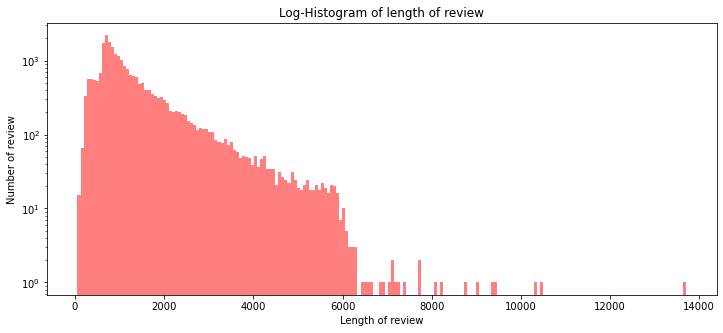

In [8]:
# 각 리뷰의 문자 길이 분포 _ 시각화

# 그래프 이미지 크기 선언
# figsize: (가로, 세로)의 튜플 형태로 선언
plt.figure(figsize = (12,5))

# 히스토그램 선언
# bins: 히스토그램 값에 대한 버킷 범위 (히스토그램의 계급의 크기) 
# cf. 히스토그램은 도수 분포를 확인할 수 있는 그래프라, x만 정하면 그에 해당하는 빈도수가 y축 값이 됨
# range: x축 값의 범위
# alpha: 그래프 색 투명도
# color: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_length, bins = 200, alpha = 0.5, color = 'r', label = 'word')
plt.yscale('log', nonposy = 'clip')

# 그래프 제목
plt.title('Log-Histogram of length of review')
# 그래프 축별 라벨
plt.xlabel('Length of review')
plt.ylabel('Number of review')

In [9]:
print('리뷰 길이 최대값:', train_length.max())
print('리뷰 길이 최소값:', train_length.min())
print('리뷰 길이 평균값: {:.2f}'.format(train_length.mean()))
print('리뷰 길이 표준편차: {:.2f}'.format(train_length.std()))
print('리뷰 길이 표준편차(np.std): {:.2f}'.format(np.std(train_length))) # 왜 np에서 계산한 거랑 위랑 결과가 다를까..
print('리뷰 길이 중간값:', train_length.median())
print('리뷰 길이 제 1 사분위:', np.percentile(train_length, 25))
print('리뷰 길이 제 3 사분위:', np.percentile(train_length, 75))

리뷰 길이 최대값: 13710
리뷰 길이 최소값: 54
리뷰 길이 평균값: 1329.71
리뷰 길이 표준편차: 1005.24
리뷰 길이 표준편차(np.std): 1005.22
리뷰 길이 중간값: 983.0
리뷰 길이 제 1 사분위: 705.0
리뷰 길이 제 3 사분위: 1619.0


{'whiskers': [<matplotlib.lines.Line2D at 0x134cdea8e80>,
 'caps': [<matplotlib.lines.Line2D at 0x134cdebe5c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x134cdea8b70>],
 'medians': [<matplotlib.lines.Line2D at 0x134cdebecc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x134cdec83c8>],
 'means': [<matplotlib.lines.Line2D at 0x134cdec8080>]}

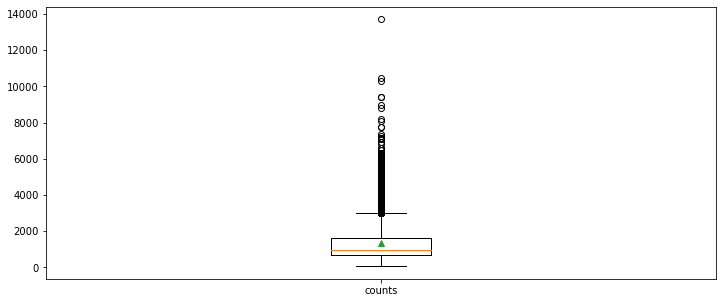

In [10]:
plt.figure(figsize = (12,5))
# 박스 플롯 만들 것
# 첫번째 parameter: 여러 분포에 대한 데이터 리스트 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값 마크할 것

plt.boxplot(train_length,
           labels = ['counts'],
           showmeans = True)

(-0.5, 799.5, 599.5, -0.5)

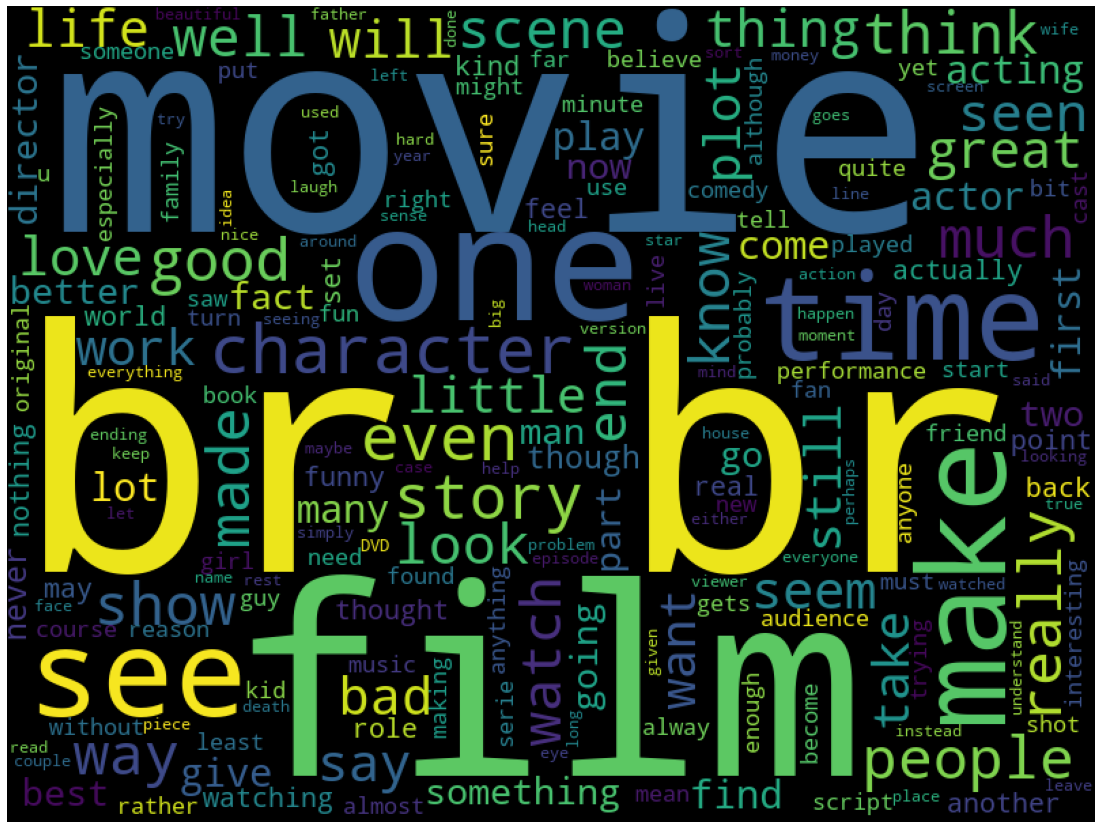

In [11]:
# 많이 사용된 단어

from wordcloud import WordCloud
cloud = WordCloud(width = 800, height = 600).generate(" ".join(train_data['review']))
plt.figure(figsize= (20,15))
plt.imshow(cloud)
plt.axis('off')

c:\programdata\anaconda3\envs\pr_tensorflow\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


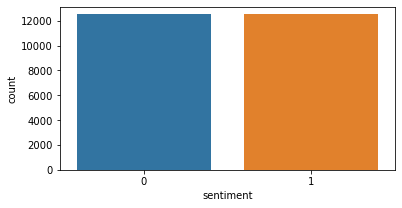

In [12]:
# 긍정/부정 데이터 분포

fig, axe = plt.subplots(ncols = 1) # axe에 할당되는 값이 뭐지?
fig.set_size_inches(6,3)
sns.countplot(train_data['sentiment'])

In [13]:
print('긍정 리뷰 개수: {}'.format(train_data['sentiment'].value_counts()[1]))
print('부정 리뷰 개수: {}'.format(train_data['sentiment'].value_counts()[0]))

긍정 리뷰 개수: 12500
부정 리뷰 개수: 12500


In [14]:
# 각 리뷰의 단어 개수 분포

train_word_counts = train_data['review'].apply(lambda x: len(x.split(' '))) # 띄어쓰기가 단어의 기준이라고 가정할 때

Text(0, 0.5, 'Number of reviews')

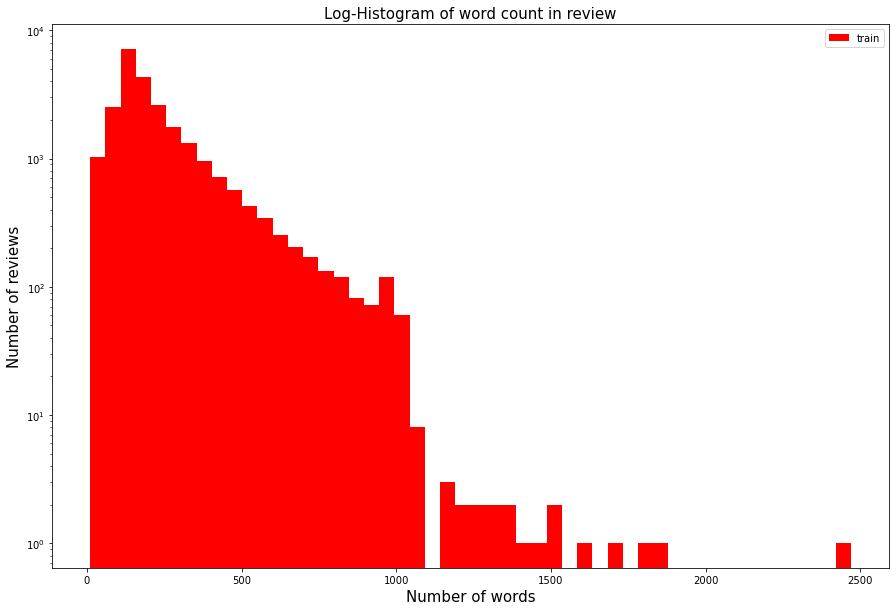

In [15]:
plt.figure(figsize = (15, 10))
plt.hist(train_word_counts, bins = 50, facecolor = 'r', label = 'train')
plt.title('Log-Histogram of word count in review', fontsize = 15)
plt.yscale('log', nonposy = 'clip')
plt.legend()
plt.xlabel('Number of words', fontsize = 15)
plt.ylabel('Number of reviews', fontsize = 15)

In [16]:
print('리뷰 단어 개수 최대값:', train_word_counts.max())
print('리뷰 단어 개수 최소값:', train_word_counts.min())
print('리뷰 단어 개수 평균값: {:.2f}'.format(train_word_counts.mean()))
print('리뷰 단어 개수 평균값(np.mean): {:.2f}'.format(np.mean(train_word_counts)))
print('리뷰 단어 개수 표준편차: {:.2f}'.format(train_word_counts.std()))
print('리뷰 단어 개수 표준편차(np.std): {:.2f}'.format(np.std(train_word_counts)))
print('리뷰 단어 개수 중간값:', train_word_counts.median())
print('리뷰 단어 개수 제 1 사분위:', np.percentile(train_word_counts, 25))
print('리뷰 단어 개수 제 3 사분위:', np.percentile(train_word_counts, 75))

리뷰 단어 개수 최대값: 2470
리뷰 단어 개수 최소값: 10
리뷰 단어 개수 평균값: 233.79
리뷰 단어 개수 평균값(np.mean): 233.79
리뷰 단어 개수 표준편차: 173.75
리뷰 단어 개수 표준편차(np.std): 173.74
리뷰 단어 개수 중간값: 174.0
리뷰 단어 개수 제 1 사분위: 127.0
리뷰 단어 개수 제 3 사분위: 284.0


In [17]:
# 특수문자 및 대/소문자 비율

qmarks = np.mean(train_data['review'].apply(lambda x: '?' in x)) # 물음표가 들어있는 비율
fullstop = np.mean(train_data['review'].apply(lambda x: '.' in x)) # 마침표가 들어있는 비율
capital_first = np.mean(train_data['review'].apply(lambda x : x[0].isupper())) # 첫글자가 대문자인 비율...?
capitals = np.mean(train_data['review'].apply(lambda x: max([y.isupper() for y in x]))) # (각 리뷰마다 대문자가 하나 있으면 1이 됨! 즉 대문자가 있는 질문의 비율
numbers = np.mean(train_data['review'].apply(lambda x: max([y.isdigit() for y in x]))) # 숫자가 있는 리뷰 비율

In [18]:
print('물음표가 있는 질문: {:.2f}%'.format(qmarks*100))
print('마침표가 있는 질문: {:.2f}%'.format(fullstop*100))
print('첫 글자가 대문자인 질문: {:.2f}%'.format(capital_first*100))
print('대문자가 있는 질문: {:.2f}%'.format(capitals*100))
print('숫자가 있는 질문: {:.2f}%'.format(numbers*100))

물음표가 있는 질문: 29.55%
마침표가 있는 질문: 99.69%
첫 글자가 대문자인 질문: 0.00%
대문자가 있는 질문: 99.59%
숫자가 있는 질문: 56.66%


## 데이터 전처리


In [19]:
import re
import json
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

In [20]:
DATA_IN_PATH = './data_in/'

train_data = pd.read_csv(DATA_IN_PATH+'labeledTrainData.tsv', header = 0, delimiter = '\t', quoting = 3)
print(train_data['review'][0])

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [21]:
review = train_data['review'][0]
review_text = BeautifulSoup(review, "html5lib").get_text() # HTML 태그 제거
review_text = re.sub('[^a-zA-Z]', " ", review_text) # 영문자 제외한 모든 문자 공백으로 substitute

In [22]:
print(review_text)

 With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring  Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him The actual feature film bit when it finally starts is only on for    mi

In [23]:
stop_words = set(stopwords.words('english')) # 영어의 불용어 set 만듦

review_text = review_text.lower() # 전부 소문자로 만듦
words = review_text.split() # 소문자 변환 후 단어마다 나눠서 단어 리스트로 만든다
words = [w for w in words if not w in stop_words]

In [24]:
print(words)

['stuff', 'going', 'moment', 'mj', 'started', 'listening', 'music', 'watching', 'odd', 'documentary', 'watched', 'wiz', 'watched', 'moonwalker', 'maybe', 'want', 'get', 'certain', 'insight', 'guy', 'thought', 'really', 'cool', 'eighties', 'maybe', 'make', 'mind', 'whether', 'guilty', 'innocent', 'moonwalker', 'part', 'biography', 'part', 'feature', 'film', 'remember', 'going', 'see', 'cinema', 'originally', 'released', 'subtle', 'messages', 'mj', 'feeling', 'towards', 'press', 'also', 'obvious', 'message', 'drugs', 'bad', 'kay', 'visually', 'impressive', 'course', 'michael', 'jackson', 'unless', 'remotely', 'like', 'mj', 'anyway', 'going', 'hate', 'find', 'boring', 'may', 'call', 'mj', 'egotist', 'consenting', 'making', 'movie', 'mj', 'fans', 'would', 'say', 'made', 'fans', 'true', 'really', 'nice', 'actual', 'feature', 'film', 'bit', 'finally', 'starts', 'minutes', 'excluding', 'smooth', 'criminal', 'sequence', 'joe', 'pesci', 'convincing', 'psychopathic', 'powerful', 'drug', 'lord', 

In [25]:
clean_review = ' '.join(words) # 단어 리스트들을 다시 하나의 글로 합침
print(clean_review)

stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate working

In [26]:
# 앞에서 진행한 전처리 process를 하나의 함수로 만들어 모든 review에 바로 적용하자!
def preprocessing(review, remove_stopwords = False):
    # 불용어 제거를 옵션으로 선택하게 함
    
    # 1. html 태그 제거
    review_text = BeautifulSoup(review, "html5lib").get_text()
    
    # 2. 특수문자 제거. 영문자만 남기기
    review_text = re.sub('[^a-zA-Z]', ' ', review_text)
    
    # 3. 소문자로 바꾸고 불용어 제거를 위해 사용할지도 모르는? 리스트 만들기
    words = review_text.lower().split()
    
    # 3. 불용어 제거
    if remove_stopwords:
        stops = set(stopwords.words('english'))
        words = [w for w in words if w not in stops]
        clean_review = ' '.join(words)
    else:
        clean_review = ' '.join(words)
    
    return clean_review
    

In [27]:
clean_train_reviews = []

for review in train_data['review']:
    clean_train_reviews.append(preprocessing(review, remove_stopwords = True))
    
clean_train_reviews[0]

'stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate workin

In [28]:
clean_train_df = pd.DataFrame({'review': clean_train_reviews, 'sentiment': train_data['sentiment']})

In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_reviews)
text_sequences = tokenizer.texts_to_sequences(clean_train_reviews)
# Signature: tokenizer.texts_to_sequences(texts)
# Docstring:
# Transforms each text in texts to a sequence of integers.


In [30]:
print(type(text_sequences))
print(text_sequences[:3])

<class 'list'>
[[404, 70, 419, 8815, 506, 2456, 115, 54, 873, 516, 178, 18686, 178, 11242, 165, 78, 14, 662, 2457, 117, 92, 10, 499, 4074, 165, 22, 210, 581, 2333, 1194, 11242, 71, 4826, 71, 635, 2, 253, 70, 11, 302, 1663, 486, 1144, 3265, 8815, 411, 793, 3342, 17, 441, 600, 1500, 15, 4424, 1851, 998, 146, 342, 1442, 743, 2424, 4, 8815, 418, 70, 637, 69, 237, 94, 541, 8815, 26055, 26056, 120, 1, 8815, 323, 8, 47, 20, 323, 167, 10, 207, 633, 635, 2, 116, 291, 382, 121, 15535, 3315, 1501, 574, 734, 10013, 923, 11578, 822, 1239, 1408, 360, 8815, 221, 15, 576, 8815, 22224, 2274, 13426, 734, 10013, 27, 28606, 340, 16, 41, 18687, 1500, 388, 11243, 165, 3962, 8815, 115, 627, 499, 79, 4, 8815, 1430, 380, 2163, 114, 1919, 2503, 574, 17, 60, 100, 4875, 5100, 260, 1268, 26057, 15, 574, 493, 744, 637, 631, 3, 394, 164, 446, 114, 615, 3266, 1160, 684, 48, 1175, 224, 1, 16, 4, 8815, 3, 507, 62, 25, 16, 640, 133, 231, 95, 7426, 600, 3439, 8815, 37248, 1864, 1, 128, 342, 1442, 247, 3, 865, 16, 42, 148

In [31]:
word_vocab = tokenizer.word_index
print(word_vocab)

{'movie': 1, 'film': 2, 'one': 3, 'like': 4, 'good': 5, 'time': 6, 'even': 7, 'would': 8, 'story': 9, 'really': 10, 'see': 11, 'well': 12, 'much': 13, 'get': 14, 'bad': 15, 'people': 16, 'also': 17, 'first': 18, 'great': 19, 'made': 20, 'way': 21, 'make': 22, 'could': 23, 'movies': 24, 'think': 25, 'characters': 26, 'character': 27, 'watch': 28, 'two': 29, 'films': 30, 'seen': 31, 'many': 32, 'life': 33, 'plot': 34, 'acting': 35, 'never': 36, 'love': 37, 'little': 38, 'best': 39, 'show': 40, 'know': 41, 'ever': 42, 'man': 43, 'better': 44, 'end': 45, 'still': 46, 'say': 47, 'scene': 48, 'scenes': 49, 'go': 50, 'something': 51, 'back': 52, 'real': 53, 'watching': 54, 'though': 55, 'thing': 56, 'old': 57, 'years': 58, 'actors': 59, 'director': 60, 'work': 61, 'another': 62, 'new': 63, 'nothing': 64, 'funny': 65, 'actually': 66, 'makes': 67, 'look': 68, 'find': 69, 'going': 70, 'part': 71, 'lot': 72, 'every': 73, 'world': 74, 'cast': 75, 'us': 76, 'quite': 77, 'want': 78, 'things': 79, 'p

In [32]:
print('전체 단어 수:',len(word_vocab))

전체 단어 수: 74065


In [33]:
# 단어 사전, 전체 단어 개수 저장해두기
data_config = {}
data_config['vocab'] = word_vocab
data_config['vocab_size'] = len(word_vocab)

In [34]:
# 패딩 처리 (최대 len 정하고, 부족하면 0으로 패딩, 넘치면 자르는 처리)

MAX_SEQUENCE_LENGTH = 174 # 단어 개수 통계의 중간값

train_inputs = pad_sequences(text_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')

print('Shape of train data:', train_inputs.shape)

Shape of train data: (25000, 174)


In [35]:
# 라벨 나타내는 값을 넘파이 배열로 저장
train_labels = np.array(train_data['sentiment'])
print('Shape of label tensor:', train_labels.shape)

Shape of label tensor: (25000,)


In [36]:
# 앞서 전처리한 데이터 모두 저장하기!
# 1. 정제된 텍스트 데이터
# 2. 벡터화한 데이터
# 3. 정답 라벨
# 4. 데이터 정보(단어 사전, 전체 단어 개수)

DATA_IN_PATH = './data_in/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
TRAIN_CLEAN_DATA = 'train_clean.csv'
DATA_CONFIGS = 'data_configs.json'

import os
if not os.path.exists(DATA_IN_PATH):
    os.makedirs(DATA_IN_PATH)

In [37]:
# 1. 정제된 데이터 numpy 형태로 저장
np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), train_labels)

# 2. 정제된 텍스트를 csv 형태로 저장
clean_train_df.to_csv(DATA_IN_PATH + TRAIN_CLEAN_DATA, index = False)

# 3. 데이터 사전을 JSON 형태로 저장
json.dump(data_config, open(DATA_IN_PATH + DATA_CONFIGS, 'w'), ensure_ascii = False)

In [38]:
# test 데이터에 대해서도 동일하게 하면 되는데, 
# 라벨 따로 저장하지 않아도 OK, 
# 데이터 정보인 단어 사전/단어 개수에 대한 정보도 학습 데이터의 것 사용하므로 저장하지 않아도 OK, 
# 단 각 리뷰 데이터에 대해 리뷰에 대한 'id' 값을 저장해야 함

test_data = pd.read_csv(DATA_IN_PATH + 'testData.tsv', header = 0, delimiter = '\t', quoting = 3)
clean_test_reviews = []

for review in test_data['review']:
    clean_test_reviews.append(preprocessing(review, remove_stopwords = True))
    
clean_test_df = pd.DataFrame({'review': clean_test_reviews, 'id': test_data['id']})
test_id = np.array(test_data['id'])

text_sequences = tokenizer.texts_to_sequences(clean_test_reviews) # str list -> list(integers) list
test_inputs = pad_sequences(text_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post') # list -> nd.array

In [42]:
type(text_sequences[0])
type(clean_test_reviews[0])

str

In [43]:
# 평가 데이터도 저장해두기!

TEST_INPUT_DATA = 'test_input.npy'
TEST_CLEAN_DATA = 'test_clean.csv'
TEST_ID_DATA = 'test_id.npy'

np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), test_inputs)
np.save(open(DATA_IN_PATH + TEST_ID_DATA, 'wb'), test_id)
clean_test_df.to_csv(DATA_IN_PATH + TEST_CLEAN_DATA, index = False)